In [58]:
import pandas as pd
import numpy as np
import re
import gc

In [49]:
# Step 1: Load the data
routes = pd.read_csv(r'../../data/tidy/google_transit/routes.txt')
trips = pd.read_csv(r'../../data/tidy/google_transit/trips.txt')
stop_times = pd.read_csv(r'../../data/tidy/google_transit/stop_times.txt')

In [50]:
# Step 2: Merge the data
# First, merge the routes with the trips on 'route_id'
route_trips = pd.merge(routes, trips, on='route_id')

# Second, merge the result with stop_times on 'trip_id'
full_data = pd.merge(route_trips, stop_times, on='trip_id')

# Step 3: Find the most common trip for each route
common_trips = full_data.groupby('route_id')['trip_id'].apply(lambda x: x.mode()[0])

# Step 4: Create a new DataFrame to hold the result
route_stop_sequences = pd.DataFrame(columns=['route_id', 'stop_sequence'])

# Step 5: Populate the new DataFrame
for route in common_trips.index:
    common_trip_id = common_trips[route]
    stop_sequence = full_data[(full_data['route_id'] == route) & (full_data['trip_id'] == common_trip_id)].sort_values('stop_sequence')['stop_id'].values
    #route_stop_sequences = route_stop_sequences.append({'route_id': route, 'stop_sequence': stop_sequence}, ignore_index=True)
    new_row = pd.DataFrame({'route_id': [route], 'stop_sequence': [stop_sequence]})
    route_stop_sequences = pd.concat([route_stop_sequences, new_row], ignore_index=True)
# Print the result
print(route_stop_sequences)

   route_id                                      stop_sequence
0        30  [34, 35, 38, 42, 58, 64, 71, 82, 93, 95, 110, ...
1        31  [157, 153, 152, 147, 133, 112, 96, 94, 81, 72,...
2        33  [127, 130, 128, 125, 124, 9050, 9051, 9052, 96...
3        36  [48, 51, 41, 44, 46, 58, 64, 71, 82, 93, 95, 1...
4        45  [58, 64, 71, 82, 93, 95, 110, 106, 109, 102, 9...
5        46  [72, 63, 56, 43, 37, 31, 9055, 19, 18, 14, 13,...
6       801  [1775, 1768, 1763, 1757, 1753, 1747, 1738, 174...
7       802  [1007, 1068, 1093, 1127, 1157, 1187, 1233, 126...
8       803  [9142, 6435, 6433, 9151, 1147, 1176, 1201, 122...
9       804  [1000, 1024, 1052, 1083, 1112, 1117, 1152, 119...
10      805  [1007, 1068, 1093, 1127, 1157, 1187, 1233, 126...
11      806  [9141, 922, 942, 944, 954, 977, 1035, 1065, 11...
12      820  [11003, 461, 464, 468, 500, 513, 541, 551, 556...
13      821  [916, 955, 970, 1002, 1051, 1077, 1104, 1208, ...
14      823  [11003, 461, 464, 468, 471, 472, 476, 492,

In [51]:
route_stop_sequences.to_csv(r'../../results/route-stop-sequences.csv')

In [74]:
df =pd.read_csv(r'../../results/computed-fuel-rates-oct2021-sep2022.csv', low_memory=False)

In [53]:
# replace all occurrences of '(X)' with an empty string
df['Route'] = df['Route'].str.replace(r'\(X\)|\(\)', '', regex=True)

In [54]:
df['Route'] = df['Route'].str.lstrip()

In [55]:
df['Route'].nunique()

53

In [56]:
# Convert route_stop_sequences DataFrame to a dictionary
stop_sequence_dict = route_stop_sequences.set_index('route_id')['stop_sequence'].apply(list).to_dict()

# Helper function to convert stop to its index in the sequence
def get_stop_index(row):
    route = row['Route']
    stop = row['Stop']
    if route in stop_sequence_dict:
        sequence = stop_sequence_dict[route]
        if stop in sequence:
            return sequence.index(stop)
    return np.inf  # Stop is not in the sequence or route is not found

# Apply the function to create 'stop_index' column
df['stop_index'] = df.apply(get_stop_index, axis=1)

# Make sure the DataFrame is sorted by 'Date', 'Route', 'Vehicle' before running the code
df = df.sort_values(['Date', 'Route', 'Vehicle'])

# Initialize 'run' as 1
df['run'] = 1

def calculate_runs(group):
    route = group.name[0]
    if route not in stop_sequence_dict:
        return pd.Series(np.inf, index=group.index) # or return whatever makes sense in your context
    sequence_length = len(stop_sequence_dict[route])
    return ((group['stop_index'] == 0) | (group['stop_index'] == sequence_length - 1)).cumsum()

# For each group of 'Route', 'Date', 'Vehicle', apply calculate_runs function
df['run'] = df.groupby(['Route', 'Date', 'Vehicle']).apply(calculate_runs).values

# Set 'run' as np.inf wherever 'stop_index' is np.inf
df.loc[df['stop_index'] == np.inf, 'run'] = np.inf

In [57]:
# Get a list of column names matching the pattern
pattern = re.compile(r'^Unnamed: 0\.\d+$')
columns_to_drop = [col for col in df.columns if pattern.match(col)]

# Drop the columns from the DataFrame
df = df.drop(columns=columns_to_drop)

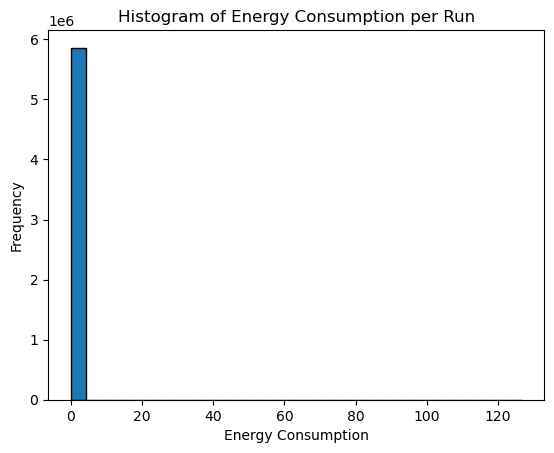

In [61]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
df_filtered = df[(df['run'] != float('inf')) & (df['Powertrain'] != 'electric')]

plt.hist(df_filtered['Energy'], bins=30, edgecolor='black')
plt.title('Histogram of Energy Consumption per Run')
plt.xlabel('Energy Consumption')
plt.ylabel('Frequency')
plt.show()


In [62]:
df.columns

Index(['Unnamed: 0', 'ServiceDateTime', 'DateKey', 'CalendarDate', 'Year',
       'Month', 'OpKey', 'Operator', 'RtKey', 'RtKey2', 'Route', 'RouteName',
       'TripKey', 'Trip', 'StopKey', 'Stop', 'StopName', 'Vehicle',
       'VehicleType', 'SeatedCap', 'TotalCap', 'Lat', 'Lon', 'Boards',
       'Alights', 'Onboard', 'Bike', 'Daytype', 'Hour', 'Minute', 'Second',
       'Date', 'Powertrain', 'VehicleModel', 'Vehicle_mass',
       'time_delta_in_seconds', 'dist', 'Speed', 'Acceleration', 'elevation',
       'grade', 'Energy', 'stop_index', 'run'],
      dtype='object')

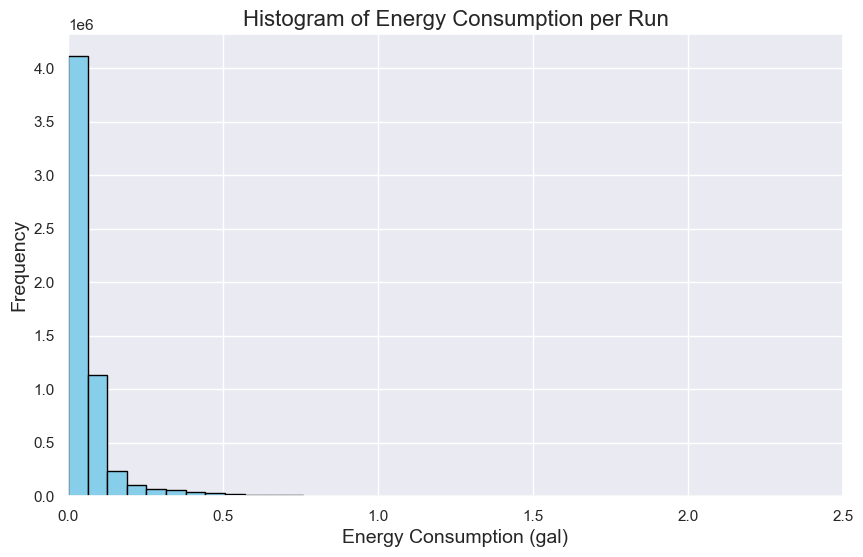

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for more beautiful plots
sns.set()

# Assuming df is your DataFrame
df_filtered = df[(df['run'] != float('inf')) & (df['Powertrain'] != 'electric')]

plt.figure(figsize=(10, 6)) # set figure size
plt.hist(df_filtered['Energy'], bins=2000, color='skyblue', edgecolor='black')
plt.title('Histogram of Energy Consumption per Run', fontsize=16)
plt.xlabel('Energy Consumption (gal)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim([0,2.5]) # set x-axis limit
plt.grid(True) # add grid
plt.show()


In [70]:
df_filtered['run'].min()

0.0

In [12]:
df.to_csv(r'../../results/computed-fuel-rates-runs-oct2021-sep2022.csv')

In [13]:
# delete the dataframe
del df

# force garbage collection
gc.collect()

0

In [14]:
df_all_CDB =pd.read_csv(r'../../results/computed-fuel-rates-all-CDB.csv', low_memory=False)

In [15]:
# replace all occurrences of '(X)' with an empty string
df_all_CDB['Route'] = df_all_CDB['Route'].str.replace(r'\(X\)|\(\)', '', regex=True)
df_all_CDB['Route'] = df_all_CDB['Route'].str.lstrip()

In [16]:
# Apply the function to create 'stop_index' column
df_all_CDB['stop_index'] = df_all_CDB.apply(get_stop_index, axis=1)

# Make sure the DataFrame is sorted by 'Date', 'Route', 'Vehicle' before running the code
df_all_CDB = df_all_CDB.sort_values(['Date', 'Route', 'Vehicle'])

# Initialize 'run' as 1
df_all_CDB['run'] = 1

# For each group of 'Route', 'Date', 'Vehicle', apply calculate_runs function
df_all_CDB['run'] = df_all_CDB.groupby(['Route', 'Date', 'Vehicle']).apply(calculate_runs).values

# Set 'run' as np.inf wherever 'stop_index' is np.inf
df_all_CDB.loc[df_all_CDB['stop_index'] == np.inf, 'run'] = np.inf

In [17]:
# Drop the columns from the DataFrame
df_all_CDB = df_all_CDB.drop(columns=columns_to_drop)

In [18]:
df_all_CDB.to_csv(r'../../results/computed-fuel-rates-runs-all-CDB.csv')

In [19]:
# delete the dataframe
del df_all_CDB

# force garbage collection
gc.collect()

0

In [20]:
df_all_HEB =pd.read_csv(r'../../results/computed-fuel-rates-all-HEB.csv', low_memory=False)

In [21]:
# replace all occurrences of '(X)' with an empty string
df_all_HEB['Route'] = df_all_HEB['Route'].str.replace(r'\(X\)|\(\)', '', regex=True)
df_all_HEB['Route'] = df_all_HEB['Route'].str.lstrip()

In [22]:
# Apply the function to create 'stop_index' column
df_all_HEB['stop_index'] = df_all_HEB.apply(get_stop_index, axis=1)

# Make sure the DataFrame is sorted by 'Date', 'Route', 'Vehicle' before running the code
df_all_HEB = df_all_HEB.sort_values(['Date', 'Route', 'Vehicle'])

# Initialize 'run' as 1
df_all_HEB['run'] = 1

# For each group of 'Route', 'Date', 'Vehicle', apply calculate_runs function
df_all_HEB['run'] = df_all_HEB.groupby(['Route', 'Date', 'Vehicle']).apply(calculate_runs).values

# Set 'run' as np.inf wherever 'stop_index' is np.inf
df_all_HEB.loc[df_all_HEB['stop_index'] == np.inf, 'run'] = np.inf

In [23]:
# Drop the columns from the DataFrame
df_all_HEB = df_all_HEB.drop(columns=columns_to_drop)

In [24]:
df_all_HEB.to_csv(r'../../results/computed-fuel-rates-runs-all-HEB.csv')

In [25]:
# delete the dataframe
del df_all_HEB

# force garbage collection
gc.collect()

0

In [26]:
df_all_BEB =pd.read_csv(r'../../results/computed-fuel-rates-all-BEB.csv', low_memory=False)

In [27]:
# replace all occurrences of '(X)' with an empty string
df_all_BEB['Route'] = df_all_BEB['Route'].str.replace(r'\(X\)|\(\)', '', regex=True)
df_all_BEB['Route'] = df_all_BEB['Route'].str.lstrip()

In [28]:
# Apply the function to create 'stop_index' column
df_all_BEB['stop_index'] = df_all_BEB.apply(get_stop_index, axis=1)

# Make sure the DataFrame is sorted by 'Date', 'Route', 'Vehicle' before running the code
df_all_BEB = df_all_BEB.sort_values(['Date', 'Route', 'Vehicle'])

# Initialize 'run' as 1
df_all_BEB['run'] = 1

# For each group of 'Route', 'Date', 'Vehicle', apply calculate_runs function
df_all_BEB['run'] = df_all_BEB.groupby(['Route', 'Date', 'Vehicle']).apply(calculate_runs).values

# Set 'run' as np.inf wherever 'stop_index' is np.inf
df_all_BEB.loc[df_all_BEB['stop_index'] == np.inf, 'run'] = np.inf

In [29]:
# Drop the columns from the DataFrame
df_all_BEB = df_all_BEB.drop(columns=columns_to_drop)

In [30]:
df_all_BEB.to_csv(r'../../results/computed-fuel-rates-runs-all-BEB.csv')

In [31]:
# delete the dataframe
del df_all_BEB

# force garbage collection
gc.collect()

0

In [35]:
df_all_CDB_run =pd.read_csv(r'../../results/computed-fuel-rates-runs-all-CDB.csv', low_memory=False)

In [36]:
# Assuming 'Energy' is a column in your DataFrame df
df_all_CDB_run_grouped = df_all_CDB_run.groupby(['Vehicle', 'Date', 'Route', 'run'])['Energy'].sum().reset_index()

In [37]:
df_all_CDB_run_grouped.to_csv(r'../../results/computed-fuel-rates-runs-grouped-all-CDB.csv')

In [38]:
# delete the dataframe
del df_all_CDB_run
del df_all_CDB_run_grouped

# force garbage collection
gc.collect()

33420

In [40]:
df_all_HEB_run =pd.read_csv(r'../../results/computed-fuel-rates-runs-all-HEB.csv', low_memory=False)

In [41]:
# Assuming 'Energy' is a column in your DataFrame df
df_all_HEB_run_grouped = df_all_HEB_run.groupby(['Vehicle', 'Date', 'Route', 'run'])['Energy'].sum().reset_index()

In [42]:
df_all_HEB_run_grouped.to_csv(r'../../results/computed-fuel-rates-runs-grouped-all-HEB.csv')

In [43]:
# delete the dataframe
del df_all_HEB_run
del df_all_HEB_run_grouped

# force garbage collection
gc.collect()

2849

In [44]:
df_all_BEB_run =pd.read_csv(r'../../results/computed-fuel-rates-runs-all-BEB.csv', low_memory=False)

In [45]:
# Assuming 'Energy' is a column in your DataFrame df
df_all_BEB_run_grouped = df_all_BEB_run.groupby(['Vehicle', 'Date', 'Route', 'run'])['Energy'].sum().reset_index()

In [46]:
df_all_BEB_run_grouped.to_csv(r'../../results/computed-fuel-rates-runs-grouped-all-BEB.csv')

In [47]:
# delete the dataframe
del df_all_BEB_run
del df_all_BEB_run_grouped

# force garbage collection
gc.collect()

0

In [79]:
df.columns

Index(['Unnamed: 0.4', 'Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1',
       'Unnamed: 0', 'ServiceDateTime', 'DateKey', 'CalendarDate', 'Year',
       'Month', 'OpKey', 'Operator', 'RtKey', 'RtKey2', 'Route', 'RouteName',
       'TripKey', 'Trip', 'StopKey', 'Stop', 'StopName', 'Vehicle',
       'VehicleType', 'SeatedCap', 'TotalCap', 'Lat', 'Lon', 'Boards',
       'Alights', 'Onboard', 'Bike', 'Daytype', 'Hour', 'Minute', 'Second',
       'Date', 'Powertrain', 'VehicleModel', 'Vehicle_mass',
       'time_delta_in_seconds', 'dist', 'Speed', 'Acceleration', 'elevation',
       'grade', 'Energy'],
      dtype='object')

In [80]:
len(df['TripKey'].unique())

88013

In [81]:
df['ServiceDateTime'] = pd.to_datetime(df['ServiceDateTime'])
df['Date'] = df['ServiceDateTime'].dt.date

# Find the unique routes per vehicle per day
routes_per_vehicle_per_day = df.groupby(['Date', 'Vehicle'])['Route'].nunique()

# Find the max number of unique routes a vehicle can operate in each given day
max_routes_per_vehicle_per_day = routes_per_vehicle_per_day.groupby('Date').max()

print(max_routes_per_vehicle_per_day)


Date
2021-10-01    5
2021-10-02    4
2021-10-03    3
2021-10-04    4
2021-10-05    6
             ..
2022-09-26    6
2022-09-27    6
2022-09-28    7
2022-09-29    6
2022-09-30    6
Name: Route, Length: 363, dtype: int64


In [84]:
max_routes_across_all_vehicles = routes_per_vehicle_per_day.max()
print(max_routes_across_all_vehicles)

7
